# Electrification of Heat: Building source input/output table

The purpose of this notebook is to build the models that will be used to calculate the price recommentation for a heat pump for the EoH programme. The model uses a training set of houses that were surveyed by various surveyeors and subsequently had HP installed by various installers. 

In [70]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from joblib import load, dump

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from scipy.interpolate import griddata

from eoh_table_aux import get_survey_datasets, replace_vars, create_output_table

import model_functions as fn

## Reading from the API and data preparation
This data is not anonymized so when public is this part of the code will not work. 

In [71]:
df_survey, df_hp, df_epc = get_survey_datasets()

working with data from surveyor: ovo
working with data from surveyor: warmworks
working with data from surveyor: e.on


In [72]:
# Make sure the house key is of the same type for joins
df_survey['House_ID'] = df_survey['House_ID'].astype(str)
df_epc['House_ID'] = df_epc['House_ID'].astype(str)
df_hp['House_ID'] = df_hp['House_ID'].astype(str)    

We will present total costs only so here we do the sum of installation and equipment cost. Also do some cleaning in `df_hp`

In [73]:
df_hp['total_cost'] = df_hp['Cost_HP'].replace(np.nan,0) + df_hp['Cost_Install'].replace(np.nan,0)
print('Installed HP before consolidation')
df_hp = fn.consolidate_hp_types(df_hp)
df_hp.loc[df_hp['HP_Brand']=='Vailant', 'HP_Brand'] = 'Vaillant'
print('')
print('Installed HP after consolidation')
df_hp['HP_Installed'].value_counts()

Installed HP before consolidation
ASHP                     307
HT_ASHP                  244
Hybrid_Monobloc          126
GSHP_Borehole             22
GSHP                      16
Hybrid_Split_Existing     11
Hybrid_Split_New           9
Hybrid                     5
Hybrid_split_new           2
Name: HP_Installed, dtype: int64

Installed HP after consolidation


ASHP       307
HT_ASHP    244
Hybrid     153
GSHP        38
Name: HP_Installed, dtype: int64

From the survey df we take the `MCS_SHLoad` parameter so we do some cleaning. 

In [74]:
# Some House_IDs have .0 on the end in this dataset but not others - remove them
df_survey['House_ID'] = df_survey['House_ID'].astype(int, errors='ignore')
df_survey['House_ID'] = df_survey['House_ID'].astype(str)
df_survey['House_ID'] = df_survey['House_ID'].str.split('.', expand = True)[0] # trick to remove .0 from strings..

In [75]:
# Some House_IDs have duplicates - remove these, keeping the one with the most detailed comments (and then highest MCS_SHLoad)
duplicate_house_ids = df_survey.loc[df_survey['House_ID'].duplicated(), 'House_ID'].unique()
deduped_df_survey = df_survey[df_survey['House_ID'].isin(duplicate_house_ids)].sort_values(['House_ID', 'HP_NoRec_R1', 'MCS_SHLoad']).drop_duplicates('House_ID', keep='last')
df_survey = pd.concat([df_survey[~df_survey['House_ID'].isin(duplicate_house_ids)], deduped_df_survey])

In [76]:
# select heat load from survey dataset and do some cleanup.
df_survey = df_survey[['House_ID', 'MCS_SHLoad']].dropna().copy()
df_survey['MCS_SHLoad'] = df_survey['MCS_SHLoad'].astype(float)
df_survey = df_survey[df_survey['MCS_SHLoad'] < 40] # these cut removes two rows with very high and probably unlikely hl values

We now merge survey data with EPC dataset and then do some cleaning on the merged dataframe

In [77]:
# The EPC data has some duplicates - keep the latest survey that does not have a missing House_Form
df_epc = df_epc.drop(columns=['usmart_id', 'USmartHSSJson'])
df_epc = df_epc.drop_duplicates()
duplicate_house_ids = df_epc.loc[df_epc['House_ID'].duplicated(), 'House_ID'].unique()
df_epc[df_epc['House_ID'].isin(duplicate_house_ids)].sort_values(['House_ID', 'House_Form', 'Date_survey']).drop_duplicates('House_ID', keep='last')
deduped_df_epc = df_epc[df_epc['House_ID'].isin(duplicate_house_ids)].sort_values(['House_ID', 'House_Form', 'Date_survey']).drop_duplicates('House_ID', keep='last')
df_epc = pd.concat([df_epc[~df_epc['House_ID'].isin(duplicate_house_ids)], deduped_df_epc])

In [78]:
df = pd.merge(df_survey, df_epc, on='House_ID', how='inner')
df = replace_vars(df) # main cleaning fuction
# Consolidate some of the installer names
df['Name_Survey'] = df['Name_Survey'].replace({'RetrofitWorks': 'Retrofitworks', 'Retrofitworks Remote Survey': 'Retrofitworks'})
print(len(df))
df_hp_model = pd.merge(df, df_hp[['House_ID', 'HP_Size_kW', 'HP_Installed', 'HP_Brand', 'total_cost']].dropna(), on='House_ID', how='inner') # for hp size tests
print(len(df_hp_model))

840
638


In [79]:
# Filter only to installers with at least 5 installations
name_surveys = df['Name_Survey'].value_counts() >= 5
df = df[df['Name_Survey'].isin(name_surveys[name_surveys].index)]
df['Name_Survey'].value_counts()

Warmworks        337
Phoenix          186
Retrofitworks    158
Energist          71
Everwarm          43
E.ON              40
Name: Name_Survey, dtype: int64

## Analysis

The task is to map every input of the table to a heat pump size and a cost based on the data from the surveys. The survey process and the way the data was collected had a various complications that make the final dataset difficult for training a model: Although most surveyors would assign the same house a similar heat load, similar houses could end up with different size or types of HP due to different products available so the customers weren't always in position to asses full range of options. In particular, we need to calculate the HP specification/cost for all the different types of heat pump, but only one type will have been installed in a particular house.

Below we show some plots that show how the complexity of the possible distributions increases for HP sizes and HP costs. We start the distribution of total floor area an important predictor of how much energy a house requires. In the following plots we condition on houses that are detached (since those are most common in the data provided).  

Text(0.5, 1.0, 'Floor area distribution split by survey')

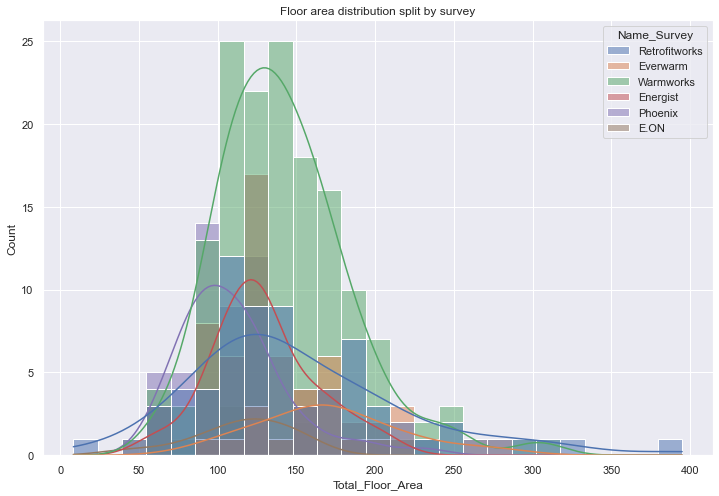

In [80]:
sns.set(rc = {'figure.figsize':(12,8)})
fig = sns.histplot(df[df['House_Form']=='Detached'], x='Total_Floor_Area', hue='Name_Survey', kde=True)
plt.title('Floor area distribution split by survey')

Next, we plot the distribution of heat loads and we notice that distrubution is still unimodal. 

Text(0.5, 1.0, 'Head load distribution split by survey')

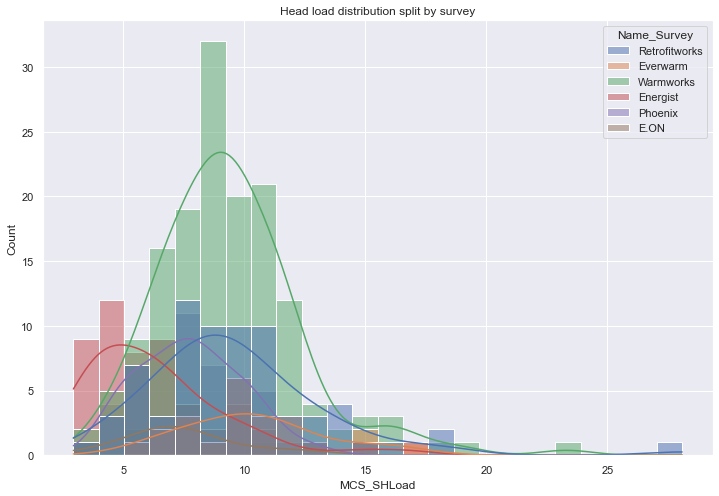

In [81]:
fig = sns.histplot(df[df['House_Form']=='Detached'], x='MCS_SHLoad', hue='Name_Survey', kde=True)
plt.title('Head load distribution split by survey')

However, as we move to the distribution of installed heat pumps the distribution is no longer unimodal.

Text(0.5, 1.0, 'Head pump size distribution split by survey')

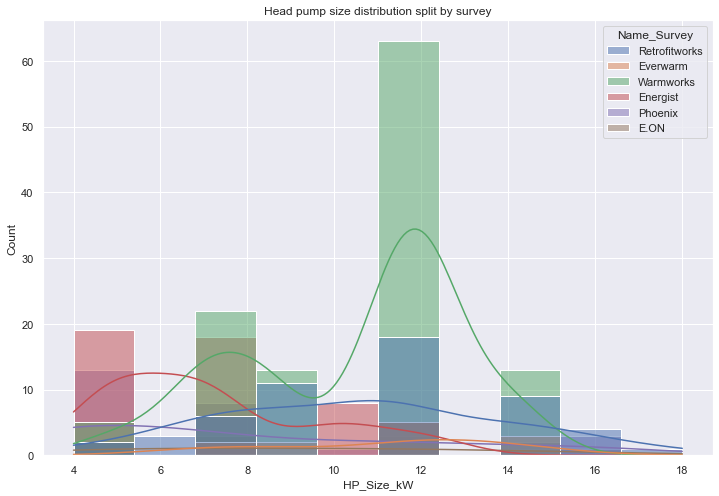

In [82]:
df_plot = pd.merge(df, df_hp, on='House_ID')
fig = sns.histplot(df_plot[df_plot['House_Form']=='Detached'], x='HP_Size_kW', hue='Name_Survey', kde=True)
plt.title('Head pump size distribution split by survey')

Moving now to the cost, we plot its distribution from the installation data, which is the main variable we want to output. 

Text(0.5, 1.0, 'Total cost distribution split by survey')

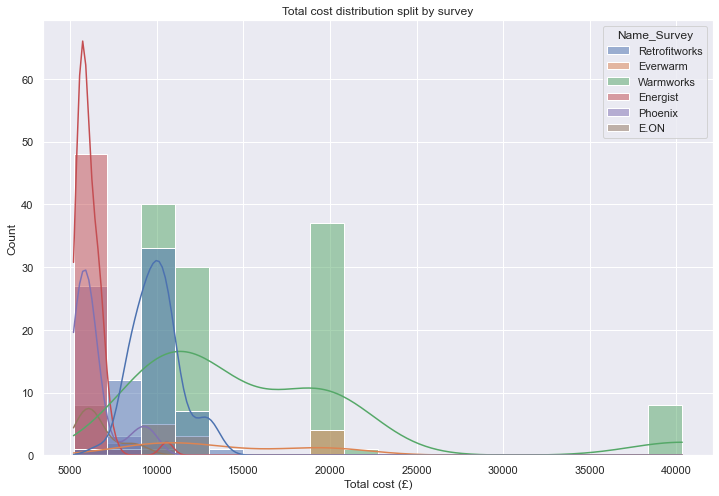

In [83]:
fig = sns.histplot(df_plot[df_plot['House_Form']=='Detached'], x='total_cost', hue='Name_Survey', kde=True)
plt.xlabel('Total cost (£)')
plt.title('Total cost distribution split by survey')

Zooming in on air-source heat pumps, we can see that different installers have different cost ranges.

Text(0.5, 1.0, 'Total cost distribution for ASHP split by survey')

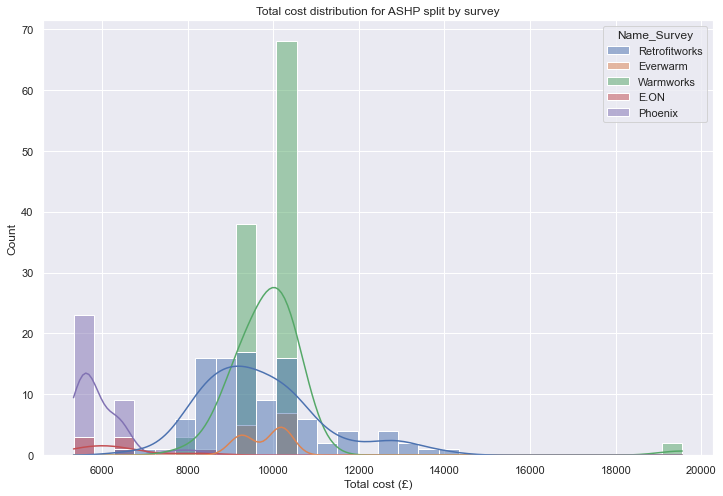

In [84]:
fig = sns.histplot(df_plot[df_plot['HP_Installed'] == 'ASHP'], x='total_cost', hue='Name_Survey', kde=True)
plt.xlabel('Total cost (£)')
plt.title('Total cost distribution for ASHP split by survey')

This is partly (but not entirely) attributable to the choice of heat pump brand

Text(0.5, 1.0, 'Total cost distribution for ASHP split by brand')

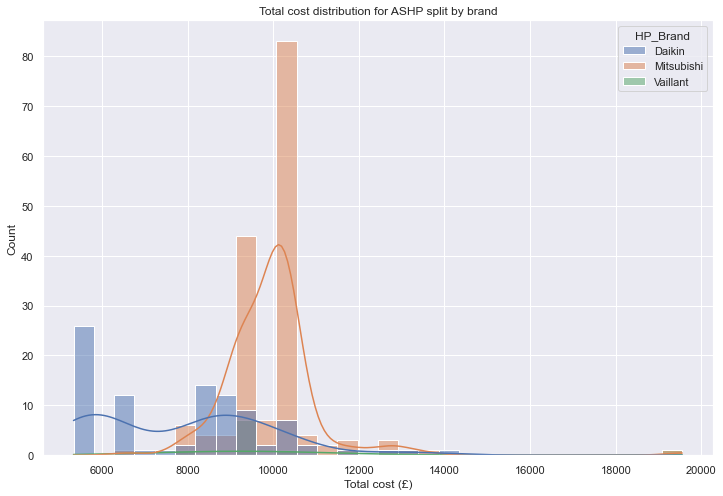

In [85]:
fig = sns.histplot(df_plot[df_plot['HP_Installed'] == 'ASHP'], x='total_cost', hue='HP_Brand', kde=True)
plt.xlabel('Total cost (£)')
plt.title('Total cost distribution for ASHP split by brand')

In fact, installer and brand make a bigger difference than heat pump size (as shown in the chart below).

Text(0.5, 1.0, 'Cost (capped at £14k) versus heat pump size')

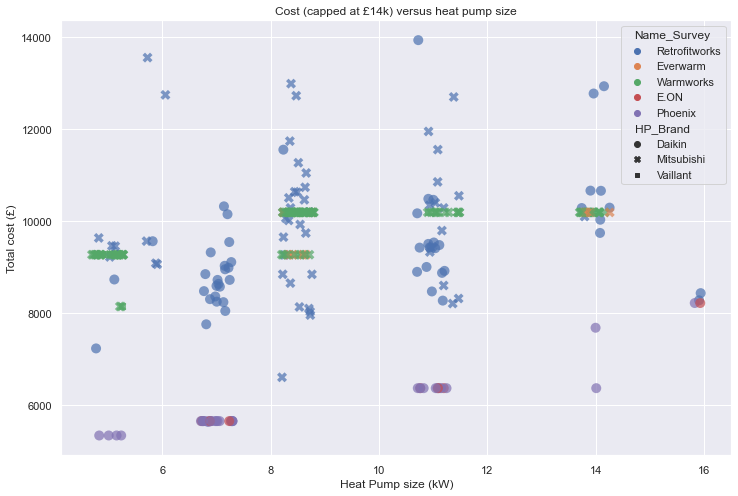

In [86]:
df_plot['HP_Size_kW_jitter'] = df_plot['HP_Size_kW'] + np.random.uniform(-0.3,0.3,len(df_plot))
fig = sns.scatterplot(data=df_plot[(df_plot['total_cost']<=14000) & (df_plot['HP_Installed'] == 'ASHP')], x='HP_Size_kW_jitter', y='total_cost', style='HP_Brand', hue='Name_Survey', s=100, edgecolor='none',alpha=0.7)
plt.ylabel('Total cost (£)')
plt.xlabel('Heat Pump size (kW)')
plt.title('Cost (capped at £14k) versus heat pump size')

We can see this more clearly if we do some quick modelling. If we build a model to predict total cost, the installer (Name_Survey) comes out as the most important feature. Removing this results in brand becoming the most important, and without brand we end up with heat pump size being the most important but the model score (R-squared) having fallen significantly from 0.48 to 0.31. This demonstrates that a lot of the observed variation in cost is explainable due to installer/brand.

In [87]:
ashp_data = df_hp_model[df_hp_model['HP_Installed'] == 'ASHP'].copy()
ashp_data = ashp_data[['House_Form', 'House_Age', 'Name_Survey', 'Bedrooms', 'Total_Floor_Area', 'No_Occupants', 'HP_Size_kW', 'Wall_Type', 'total_cost', 'HP_Brand']]

Model score: 0.48


<AxesSubplot:>

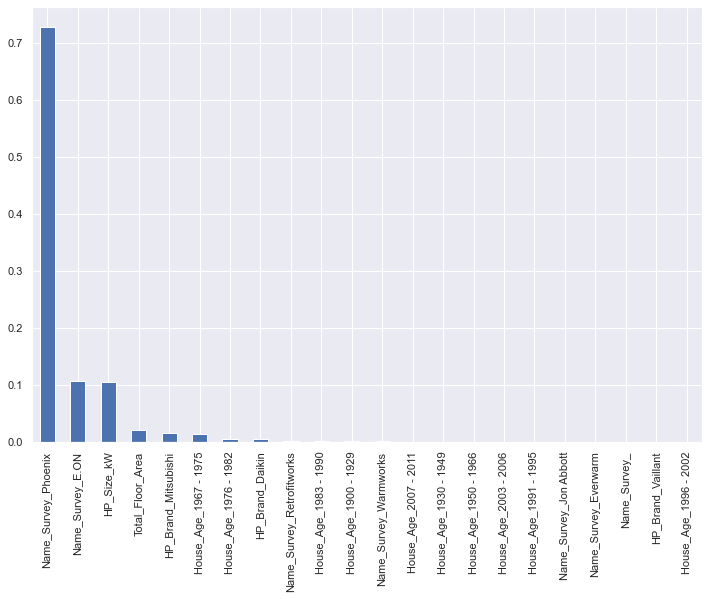

In [88]:
x = ashp_data[['Total_Floor_Area','HP_Size_kW']]
y = ashp_data['total_cost']
for cat_col in ['HP_Brand', 'Name_Survey', 'House_Age']:
    cols = pd.get_dummies(ashp_data[cat_col], prefix=cat_col)
    x = pd.concat([x, cols], axis=1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)    
rf = RandomForestRegressor(n_estimators=2000, max_depth=3, random_state=42)
model = rf.fit(x_train, y_train)
score = model.score(x_test, y_test).round(2)
print(f'Model score: {score}')

forest_importances = pd.Series(model.feature_importances_, index=x.columns).sort_values(ascending=False)
forest_importances.plot.bar()

Model score: 0.3


<AxesSubplot:>

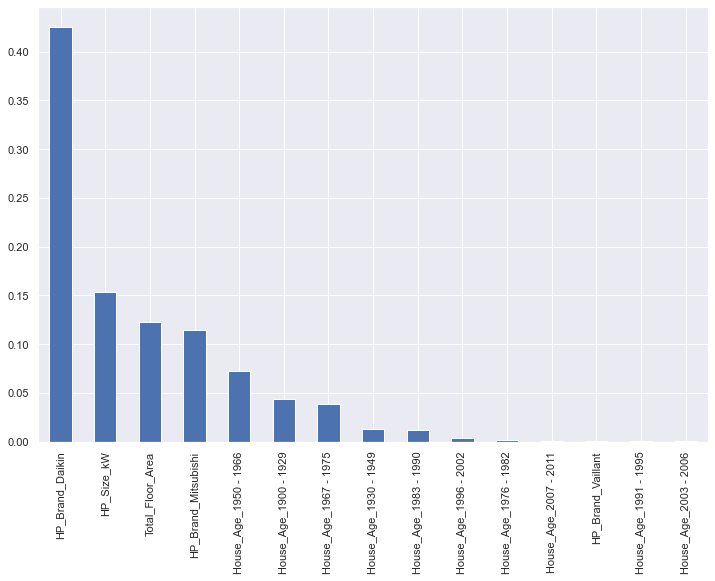

In [89]:
x = ashp_data[['Total_Floor_Area','HP_Size_kW']]
y = ashp_data['total_cost']
for cat_col in ['HP_Brand', 'House_Age']:
    cols = pd.get_dummies(ashp_data[cat_col], prefix=cat_col)
    x = pd.concat([x, cols], axis=1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)    
rf = RandomForestRegressor(n_estimators=2000, max_depth=3, random_state=42)
model = rf.fit(x_train, y_train)
score = model.score(x_test, y_test).round(2)
print(f'Model score: {score}')

forest_importances = pd.Series(model.feature_importances_, index=x.columns).sort_values(ascending=False)
forest_importances.plot.bar()

Model score: 0.31


<AxesSubplot:>

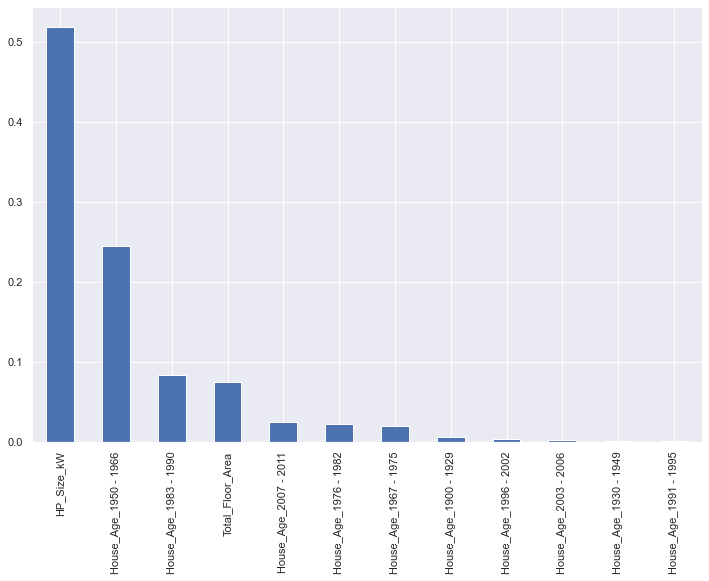

In [90]:
x = ashp_data[['Total_Floor_Area','HP_Size_kW']]
y = ashp_data['total_cost']
for cat_col in ['House_Age']:
    cols = pd.get_dummies(ashp_data[cat_col], prefix=cat_col)
    x = pd.concat([x, cols], axis=1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)    
rf = RandomForestRegressor(n_estimators=2000, max_depth=3, random_state=42)
model = rf.fit(x_train, y_train)
score = model.score(x_test, y_test).round(2)
print(f'Model score: {score}')

forest_importances = pd.Series(model.feature_importances_, index=x.columns).sort_values(ascending=False)
forest_importances.plot.bar()

Given that much of the variation in the cost of a heat pump is a function of installer and HP brand, and a model without those isn't particularly predictive, we conclude that trying to directly model the cost is not the best approach. Instead, we will aim to model the size of the HP (which has some correlation with cost) and band that up into small (<7kW), medium (7-10.5kW) and large (>=10.5kW). For each HP size we will assign a cost range taken from the installation data. Note that these price ranges will be overlapping as observed in the installation data. The advantage of this approach is that it provides a framework for defining price bands from the existing data, whilst also allowing the prices for each heat pump size to be updated easily in future as costs come down over time.

## Correspondance between HP size and HP cost. 

We now use data aggregations to find the expected price ranges for a given HP size. Following discussion with the stakeholders we define a small HP as having size less the 7kW, a medium HP as having size between 7 and 10.5kW and a large HP as one with size greater than 10.5kW. 

In [91]:
hp_bins=[1, 7, 10.5]

In [92]:
# match MCS heat load with HP size and cost
df_hp['House_ID'] = df_hp['House_ID'].astype(str).values
df_hp.loc[df_hp['HP_Size_kW']=='', 'HP_Size_kW'] = 0
df_hp['HP_Size_kW'] = df_hp['HP_Size_kW'].astype(float).values
df_hp = df_hp[df_hp['HP_Size_kW']<20]
df_hp2 = pd.merge(df_survey, df_hp, on='House_ID')

dfs_hp3 = []
for hp_in in df_hp2['HP_Installed'].unique():
    df_hp3 = df_hp2[(df_hp2['HP_Installed']==hp_in)&(df_hp2['HP_Size_kW']>0)&(df_hp2['Cost_HP']>0)&(df_hp2['Cost_Install']>0)]
    df_hp3 = df_hp3[['HP_Size_kW', 'MCS_SHLoad', 'total_cost', 'HP_Brand']].groupby(
        by=['HP_Size_kW', 'HP_Brand'],as_index=False).agg({'count', 'mean', 'median', 'max', 'min'}).round(2)
    df_hp3.columns = ['_'.join(col).strip() for col in df_hp3.columns.values]
    df_hp3['HP_Installed'] = hp_in
    dfs_hp3.append(df_hp3)
df_hp3 = pd.concat(dfs_hp3)

In [93]:
df_plot.loc[df_plot['HP_Size_kW'] < hp_bins[1], 'HP_Size_kW_bin'] = 1
df_plot.loc[(df_plot['HP_Size_kW'] >= hp_bins[1]) & (df_plot['HP_Size_kW'] <= hp_bins[2]), 'HP_Size_kW_bin'] = 2
df_plot.loc[df_plot['HP_Size_kW'] > hp_bins[2], 'HP_Size_kW_bin'] = 3

From the next few tables we learn the cost ranges for a given HP size. 

First for small heat pumps:

In [94]:
df_hp.loc[(df_hp['HP_Size_kW']<hp_bins[1]),['HP_Installed', 'total_cost']].groupby(
    by=['HP_Installed'],as_index=False).agg({'count', 'median', 'mean', 'max', 'min'}).round(0).astype(int).dropna()

total_cost                          
                    max count   min median   mean
HP_Installed                                     
ASHP              13551    51  5335   9265   9010
GSHP              11605    28  5241  11605   8878
HT_ASHP           12825    51  5335   5624   8110
Hybrid           573982   135  5200   5740  10076

Then medium:

In [95]:
df_hp.loc[(df_hp['HP_Size_kW']>=hp_bins[1])&(df_hp['HP_Size_kW']<hp_bins[2]),['HP_Installed', 'total_cost']].groupby(
    by=['HP_Installed'],as_index=False).agg({'count', 'median', 'mean', 'max', 'min'}).round(0).astype(int).dropna()

total_cost                           
                    max count    min median   mean
HP_Installed                                      
ASHP              12984   153   5628   9265   8581
GSHP              40339     6  40339  40339  40339
HT_ASHP           19553   111   5648  12825  10481
Hybrid            12969     7  11788  12969  12720

Then large:

In [96]:
df_hp.loc[(df_hp['HP_Size_kW']>=hp_bins[2])&(df_hp['HP_Size_kW']<20.5),['HP_Installed', 'total_cost']].groupby(
    by=['HP_Installed'],as_index=False).agg({'count', 'median', 'mean', 'max', 'min'}).round(0).astype(int).dropna()

total_cost                           
                    max count    min median   mean
HP_Installed                                      
ASHP              19553   103   5973  10186   9541
GSHP              40339     4  40339  40339  40339
HT_ASHP           21353    82   6364  19553  15708
Hybrid            19553    11  11788  12969  13951

## Modelling of HP size

In [97]:
# costs taken from the the tables above, along with consultation with stakeholders
hp_costs = {}
hp_costs[1] = [5300,9500]
hp_costs[2] = [5600,13000]
hp_costs[3] = [6000,19600]
orig_hp_costs = hp_costs
# pd.DataFrame(hp_costs).T.to_csv('hp_costs_table.csv',index=False) # save as inputs for output table
df_out = create_output_table()

In [98]:
df_hp_model[['House_Size']].drop_duplicates()

,House_Size
0,110-200m2
2,70-90m2
3,300-400m2
4,<50m2
7,200-300m2
12,90-110m2
17,50-70m2


In [99]:
df_hp_model.head()

,House_ID,MCS_SHLoad,Outside_Access,Elec_currentuse,Postcode_1,Heated_rooms,No_Underfloor,Existing_Cooking,House_SAP,Outside_Space,...,No_Storeys,Name_Survey,Glazed_Type,TS_Existing,underfloor,House_Size,HP_Size_kW,HP_Installed,HP_Brand,total_cost
0,ZCH3870,7.28,No,3741,GU14,6,0.0,1,Unknown,Yes - Borehole,...,2,Retrofitworks,Double,Water,0,110-200m2,11.0,ASHP,Daikin,9500.02
1,ZCH2903,4.59,No,,DA9,10,0.0,1,Unknown,No,...,2,Retrofitworks,Double,Water,0,110-200m2,7.0,ASHP,Daikin,8982.05
2,ZCH2366,2.47,No,,TN25,3,0.0,0,Unknown,No,...,2,Retrofitworks,Double,Water,0,70-90m2,5.0,ASHP,Daikin,7228.02
3,ZCH3432,12.94,Yes,4400,KT11,8,1.0,0,Unknown,Yes - Borehole,...,2,Retrofitworks,Double,Water,1,300-400m2,14.0,ASHP,Daikin,12928.51
4,ZCH3283,2.93,Yes,,GU7,3,0.0,0,Unknown,Yes - Ground Loop,...,1,Retrofitworks,Double,None,0,<50m2,7.0,ASHP,Daikin,8843.77


In [100]:
# Remove this data as it doesn't make a difference to the model
df_hp_model.drop(columns=["Postcode_1"], inplace=True)

['index' 'House_Age_0' 'House_Age_1' 'House_Age_10' 'House_Age_11'
 'House_Age_2' 'House_Age_3' 'House_Age_4' 'House_Age_5' 'House_Age_6'
 'House_Age_7' 'House_Age_8' 'House_Age_9' 'House_Size_0' 'House_Size_1'
 'House_Size_2' 'House_Size_3' 'House_Size_4' 'House_Size_5'
 'House_Size_6' 'House_Form_0' 'House_Form_1' 'House_Form_2'
 'House_Form_3' 'Wall_Type_0' 'Wall_Type_1' 'Wall_Type_2' 'Wall_Type_3'
 'HP_Size_kW_bin' 'total_cost' 'HP_Installed']
working with random forest estimator...
Fitting 9 folds for each of 36 candidates, totalling 324 fits
working with nn estimator...
Fitting 9 folds for each of 48 candidates, totalling 432 fits


c:\Users\will.rowe\.conda\envs\eoh_from_leo\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Logistic Regression
              precision    recall  f1-score   support

         1.0       0.62      0.51      0.56        76
         2.0       0.52      0.50      0.51       102
         3.0       0.60      0.73      0.66        78

    accuracy                           0.57       256
   macro avg       0.58      0.58      0.58       256
weighted avg       0.57      0.57      0.57       256

Random Forest
              precision    recall  f1-score   support

         1.0       0.58      0.53      0.55        76
         2.0       0.50      0.51      0.50       102
         3.0       0.59      0.63      0.61        78

    accuracy                           0.55       256
   macro avg       0.56      0.55      0.56       256
weighted avg       0.55      0.55      0.55       256

Neural Networks
              precision    recall  f1-score   support

         1.0       0.52      0.51      0.52        76
         2.0       0.51      0.55      0.53       102
         3.0       0.67  

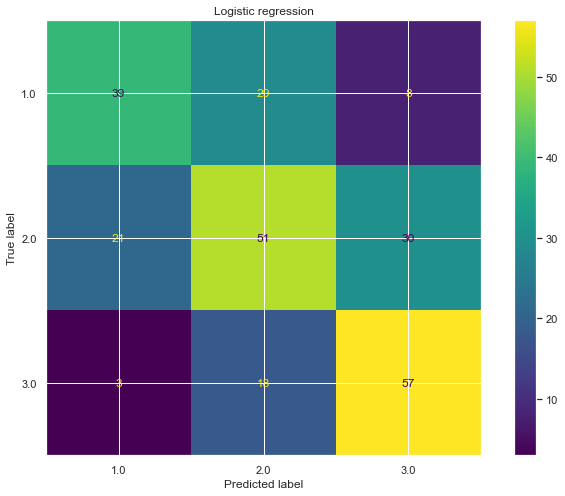

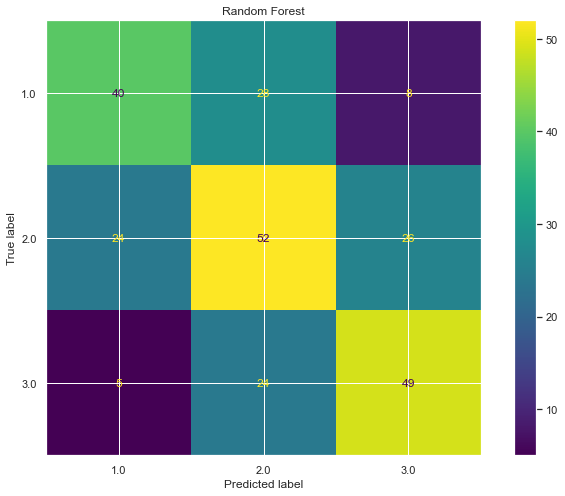

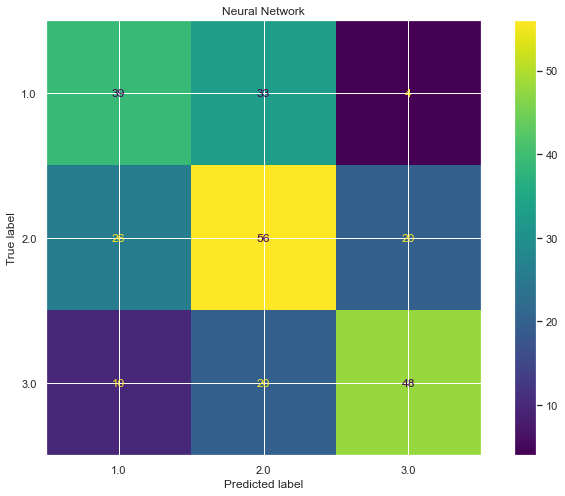

In [101]:
out_of_bounds, out_of_bounds_input = fn.run_model(df_hp_model, df_out[df_out['House_Form']!='Park Home'], 
                                                  hp_bins, hp_costs, save_artefacts=True, do_plots=True)

Now we train the model and plot the confusion matrix which shows the accuracy of our predictions. Reading the confusion matrix as columns we have the predicted label whose rows give corresponding distribution of the true labels. The optimum result is completely diagonal matrix, in practice however there will always be some misclassification with wrong labels.

Note that we build the model using all heat pump types, even though we only intend to apply it to ASHP and HT_ASHP. This is primarily because if we try to build it on just ASHP and HT_ASHP we find the resulting model is poor and just tends to predict a medium sized heat pump for every property. We suspect this is because in many of the cases where smaller heat pumps are suitable (e.g. appartments) the installer has ended up going for a different option (e.g. hybrid). However because ASHPs are technically suitable for all properties, we need to predict their sizes regardless of what was actually installed. This isn't ideal, but seems like the best choice given the data available. This is supported by the fact that the final coefficients of the model are intuitive (smaller property -> smaller heat pump).

## Final Model selection
Based on the above, the logistic regression looks to be the best choice. It is the simplest and most interpretable of the models, and has the lowest out-of-bounds percentage. We will use that as the final model

In [102]:
selected_model = load('model_artefacts/eoh_lr.joblib') 
dump(selected_model, "model_artefacts/selected_model.joblib")

['model_artefacts/selected_model.joblib']

In [103]:
df_over_under = out_of_bounds['lr'].reset_index()
df_over_under['over/under'] = 'within_bounds'
df_over_under.loc[df_over_under['cost_discr_over']<0, 'over/under'] = 'over'
df_over_under.loc[df_over_under['cost_discr_under']<0, 'over/under'] = 'under'

msk_under = df_over_under['over/under']=='under'
msk_over = df_over_under['over/under']=='over'
df_over_under['over_under'] = 0
df_over_under.loc[msk_over, 'over_under'] = -df_over_under.loc[msk_over,'cost_discr_over'].values
df_over_under.loc[msk_under, 'over_under'] = df_over_under.loc[msk_under,'cost_discr_under'].values

df_over_under['over_under_pc'] = 0
df_over_under.loc[msk_over, 'over_under_pc'] = -df_over_under.loc[msk_over, 'cost_discr_over_pc'].values
df_over_under.loc[msk_under, 'over_under_pc'] = df_over_under.loc[msk_under, 'cost_discr_under_pc'].values
df_over_under['over_under_pc'] = 100*df_over_under['over_under_pc']

Text(0.5, 0, 'payment discrepancy (%)')

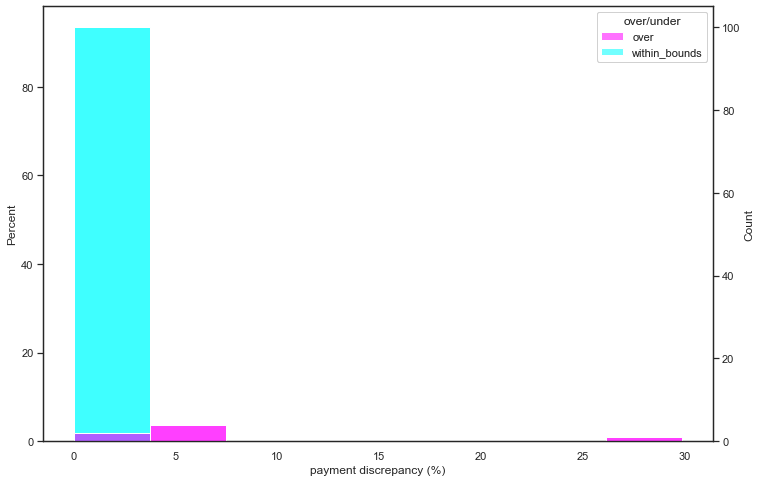

In [104]:
sns.set_style("white")
aa = len(df_over_under['over/under'].unique())
colors = ['magenta', 'cyan', 'yellow']
ax = sns.histplot(data=df_over_under, x = 'over_under_pc', stat='percent', 
                  hue='over/under', palette=colors[:aa])
ax2 = plt.twinx()
ax2 = sns.histplot(data=df_over_under, x = 'over_under_pc', stat='count', 
                   hue='over/under', palette=colors[:aa])
ax2.set_ylabel('Count')
ax2.grid(False)
ax.set_xlabel('payment discrepancy (%)')

We now check if there are price ranges that give better results than the plot above (that is with less than 15% of the houses outside the prize range). The countour plot below shows the a range of values for maximum cost of the small HP (x axis) and maximum cost of the large HP (y axis). The dotted lines cross at our current chosen set of parameters.

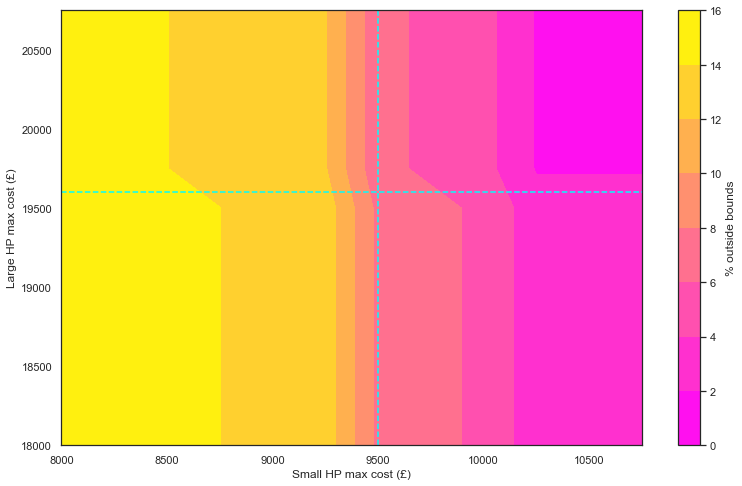

In [105]:
x = np.array([])
y = np.array([])
z = np.array([])
for i in np.arange(8000, 11000, 250):
    for j in np.arange(18000, 21000, 250):
        hp_costs_mc = {}
        hp_costs_mc[1] = [5300,i]
        hp_costs_mc[2] = [5600,13000]
        hp_costs_mc[3] = [6000,j]
        out_of_bounds = fn.out_of_bounds_metric(out_of_bounds_input[0], out_of_bounds_input[1], out_of_bounds_input[2], 
                                                out_of_bounds_input[3], out_of_bounds_input[4], out_of_bounds_input[5],
                                                hp_costs_mc, hp_type='ASHP', verbose = False)
        x = np.append(x,i)
        y = np.append(y,j)
        z = np.append(z,out_of_bounds['lr']['out_of_bounds_flg'].value_counts(normalize=True)[1])

resolution = 100
X,Y = np.mgrid[min(x):max(x):complex(resolution),   min(y):max(y):complex(resolution)]
points = [[a,b] for a,b in zip(x,y)]
Z = griddata(points, z, (X, Y), method='linear')

fig, ax = plt.subplots(figsize=(13,8))
cs = plt.contourf(X,Y,100*Z, cmap=plt.cm.spring)
cbar = fig.colorbar(cs)
cbar.ax.set_ylabel('% outside bounds')
ax.set_xlabel('Small HP max cost (£)')
ax.set_ylabel('Large HP max cost (£)')
ax.axvline(x=hp_costs[1][1], color='cyan',linestyle='--')
ax.axhline(y=hp_costs[3][1], color='cyan',linestyle='--')

In [106]:
hp_costs[3][1]

19600

We want to do a similar plot for the min and max values for each size of heat pump so we can visualize the effect of shrinking the range on accuracy of the calculation

ASHP
Original Cost Ranges:
{1: [5300, 9500], 2: [5600, 13000], 3: [6000, 19600]}
Out of bounds: 6.5420560747663545%
New Cost Ranges:
{1: [5250, 9500], 2: [8000, 10500], 3: [8000, 13000]}
Out of bounds: 18.69158878504673%
HT_ASHP
Original Cost Ranges:
{1: [5300, 9500], 2: [5600, 13000], 3: [6000, 19600]}
Out of bounds: 12.76595744680851%
New Cost Ranges:
{1: [5300, 9500], 2: [6300, 13000], 3: [6700, 19600]}
Out of bounds: 20.212765957446805%


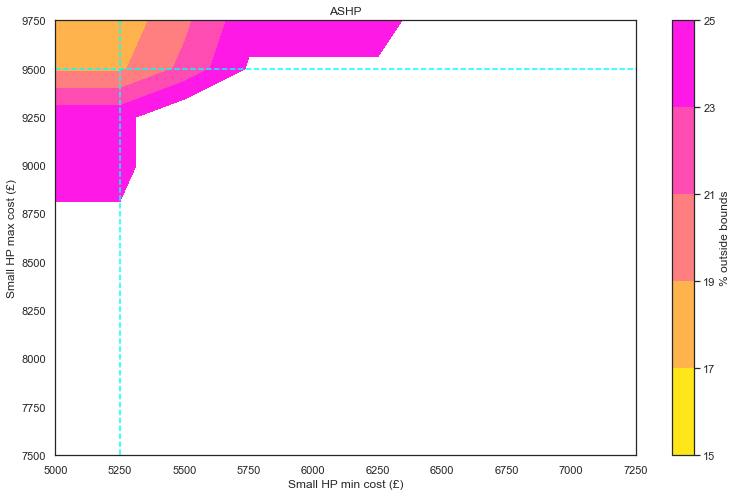

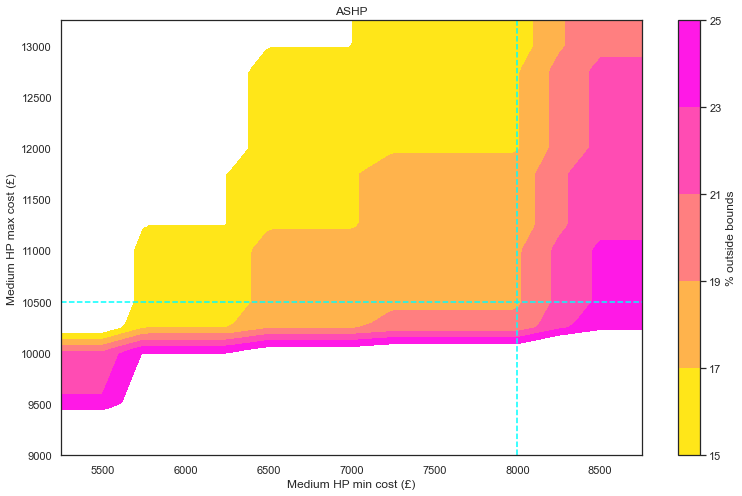

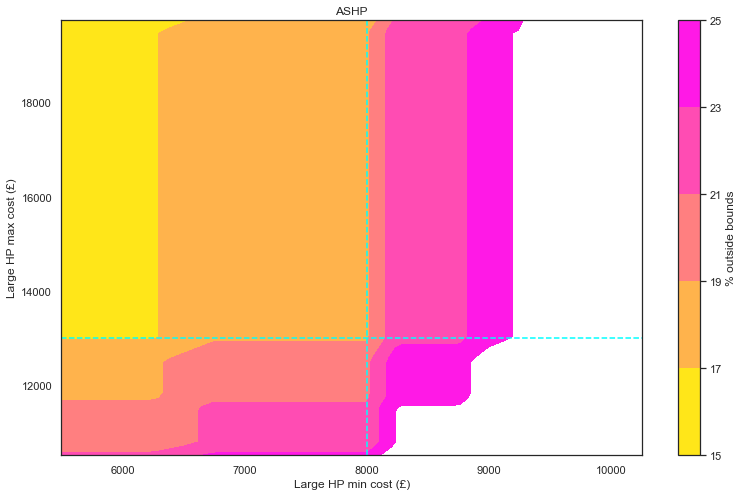

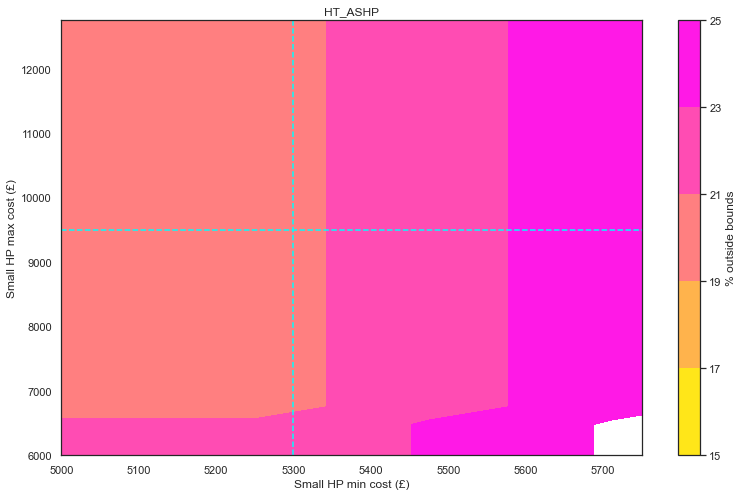

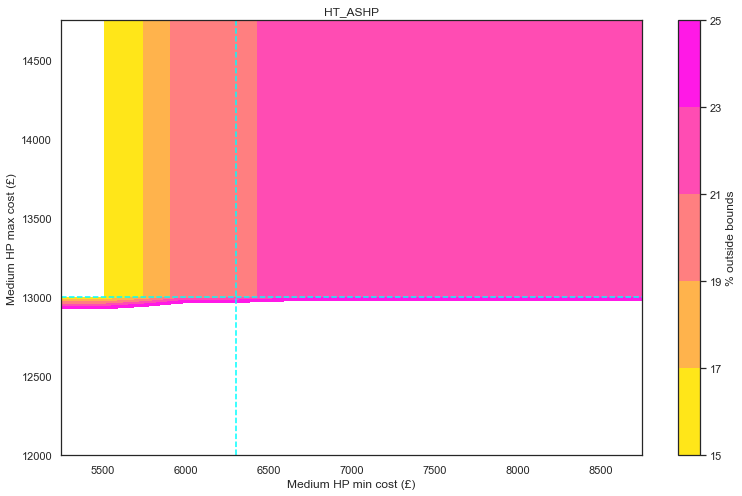

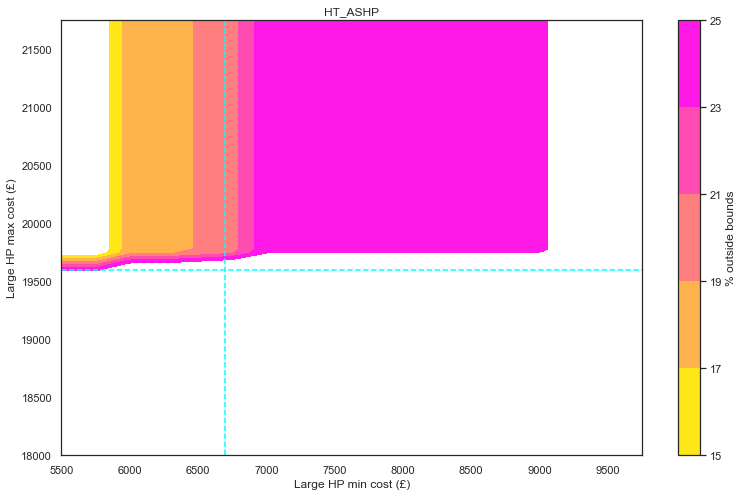

In [107]:
hp_types = ["ASHP", "HT_ASHP"]
for hp_type in hp_types:
    print(hp_type)
    hp_costs = orig_hp_costs
    # Want to do the out_of_bounds calculation for the range limits as define above
    print("Original Cost Ranges:")
    print(hp_costs)
    out_of_bounds = fn.out_of_bounds_metric(out_of_bounds_input[0], out_of_bounds_input[1], out_of_bounds_input[2], 
                                        out_of_bounds_input[3], out_of_bounds_input[4], out_of_bounds_input[5],
                                        hp_costs, hp_type=hp_type, verbose = False)
    print(f"Out of bounds: {out_of_bounds['lr']['out_of_bounds_flg'].value_counts(normalize=True)[1]*100}%")

    if hp_type == "ASHP":
        # costs taken from those define above but adjusted based on the following plots
        # this was done to reduce the size of the ranges with minimum impact to the accuracy
        hp_costs = {}
        hp_costs[1] = [5250,9500]
        hp_costs[2] = [8000,10500]
        hp_costs[3] = [8000,13000]
        
        pd.DataFrame(hp_costs).T.to_csv('ashp_costs_table.csv',index=False) # save as inputs for output table
        
        plot_range = {}
        plot_range[1] = {"min":[5000,7500], "max":[7500,10000]}
        plot_range[2] = {"min":[5250,9000], "max":[9000,13500]}
        plot_range[3] = {"min":[5500,10500], "max":[10500,20000]}

        c_range = range(15,27,2)
    elif hp_type == "HT_ASHP":
        # costs taken from those define above but adjusted based on the following plots
        # this was done to reduce the size of the ranges with minimum impact to the accuracy
        # informed input from Daniel Logue was given for these ranges
        hp_costs = {}
        hp_costs[1] = [5300,9500]
        hp_costs[2] = [6300,13000]
        hp_costs[3] = [6700,19600]
        
        pd.DataFrame(hp_costs).T.to_csv('ht_ashp_costs_table.csv',index=False) # save as inputs for output table

        plot_range = {}
        plot_range[1] = {"min":[5000,6000], "max":[6000,13000]}
        plot_range[2] = {"min":[5250,9000], "max":[12000,15000]}
        plot_range[3] = {"min":[5500,10000], "max":[18000,22000]}

        c_range = range(15,27,2)


    print("New Cost Ranges:")
    print(hp_costs)
    # Want to do the out_of_bounds calculation for the final chosen range limits
    out_of_bounds = fn.out_of_bounds_metric(out_of_bounds_input[0], out_of_bounds_input[1], out_of_bounds_input[2], 
                                        out_of_bounds_input[3], out_of_bounds_input[4], out_of_bounds_input[5],
                                        hp_costs, hp_type=hp_type, verbose = False)
    print(f"Out of bounds: {out_of_bounds['lr']['out_of_bounds_flg'].value_counts(normalize=True)[1]*100}%")

    for hp_size in range(1,4):
        x = np.array([])
        y = np.array([])
        z = np.array([])
        hp_costs_mc = {}
        hp_costs_mc[1] = hp_costs[1]
        hp_costs_mc[2] = hp_costs[2]
        hp_costs_mc[3] = hp_costs[3]
        for imin in np.arange(plot_range[hp_size]["min"][0], plot_range[hp_size]["min"][1], 250):
            for jmax in np.arange( plot_range[hp_size]["max"][0], plot_range[hp_size]["max"][1], 250):
                hp_costs_mc[hp_size] = [imin,jmax]
                out_of_bounds = fn.out_of_bounds_metric(out_of_bounds_input[0], out_of_bounds_input[1], out_of_bounds_input[2], 
                                                        out_of_bounds_input[3], out_of_bounds_input[4], out_of_bounds_input[5],
                                                        hp_costs_mc, hp_type=hp_type, verbose = False)
                x = np.append(x,imin)
                y = np.append(y,jmax)
                z = np.append(z,out_of_bounds['lr']['out_of_bounds_flg'].value_counts(normalize=True)[1])

        resolution = 100
        X,Y = np.mgrid[min(x):max(x):complex(resolution),   min(y):max(y):complex(resolution)]
        points = [[a,b] for a,b in zip(x,y)]
        Z = griddata(points, z, (X, Y), method='linear')

        fig, ax = plt.subplots(figsize=(13,8))
        cs = plt.contourf(X,Y,100*Z, cmap=plt.cm.spring_r, levels=c_range)
        
        cbar = fig.colorbar(cs)
        cbar.ax.set_ylabel('% outside bounds')
        if(hp_size==1):
            lab = "Small"
        elif(hp_size==2):
            lab = "Medium"
        else:
            lab = "Large"
        ax.set_xlabel(f'{lab} HP min cost (£)')
        ax.set_ylabel(f'{lab} HP max cost (£)')
        ax.set_title(hp_type)
        ax.axvline(x=hp_costs[hp_size][0], color='cyan',linestyle='--')
        ax.axhline(y=hp_costs[hp_size][1], color='cyan',linestyle='--')
        

Finally we plot the model coefficients. These look intuitive - small heat pumps are more likely in appartments/small houses, large heat pumps are more likely in large/detached houses.

<AxesSubplot:title={'center':'Model coefficients for Large Heat Pumps'}>

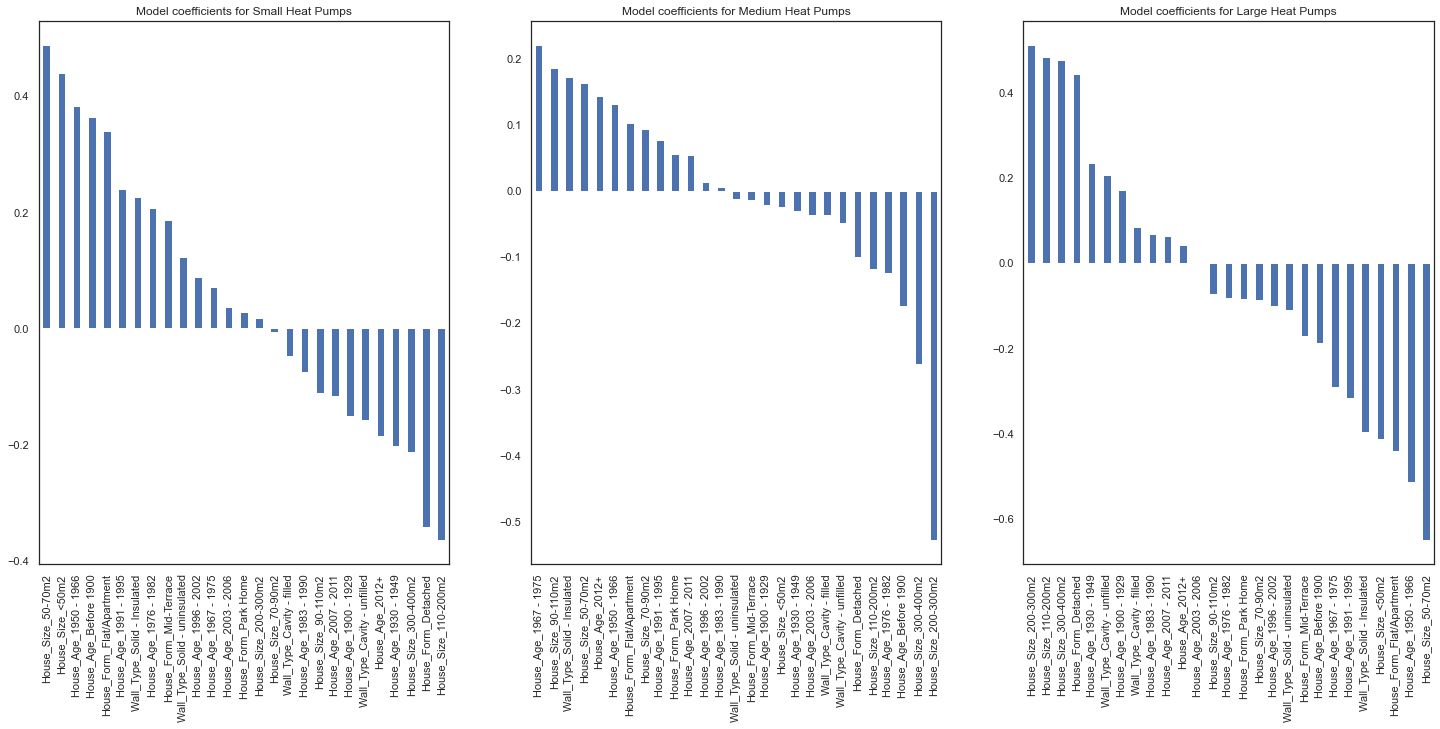

In [108]:
%%capture --no-display
lr = load('model_artefacts/eoh_lr.joblib')
df_model_inputs = fn.get_model_input_df(df_hp_model, df_out, hp_bins)
le = {}
new_colnames = pd.Series()
for cat_col in ['House_Age', 'House_Size', 'House_Form', 'Wall_Type']:
    le[cat_col] = load('model_artefacts/le_'+cat_col+'.joblib')
    matching_cols = [col for col in df_model_inputs.columns[1:-3] if cat_col in col]
    new_colnames = pd.concat([new_colnames, pd.Series(cat_col + '_' + le[cat_col].inverse_transform(range(0, len(matching_cols))))])

#fig, axs = plt.subplots(3)
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(25,10))

pd.Series(lr.coef_[0], index=new_colnames).sort_values(ascending=False).plot.bar(ax=ax1, title='Model coefficients for Small Heat Pumps')
pd.Series(lr.coef_[1], index=new_colnames).sort_values(ascending=False).plot.bar(ax=ax2, title='Model coefficients for Medium Heat Pumps')
pd.Series(lr.coef_[2], index=new_colnames).sort_values(ascending=False).plot.bar(ax=ax3, title='Model coefficients for Large Heat Pumps')

# 